In [153]:
import skimage as sk 
from skimage import io 
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import fft
from scipy.signal import gaussian

In [154]:
def read_img(im_name, to_float=False):
    im = io.imread(im_name)
    if to_float:
        im = sk.img_as_float(im).astype("float32")
    return im 

def normalize(im, to_int=False):
    normalized = (im.copy()-im.min())/(im.max()-im.min()+1e-8)
    if to_int:
        normalized = np.clip(normalized, 0, 1)
        normalized = (255*normalized).astype("uint8")
    return normalized

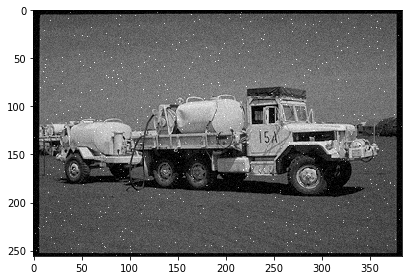

In [155]:
"""PROBLEM 1"""
noisy = read_img('./NoisyImg.bmp', True)
io.imshow(noisy)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


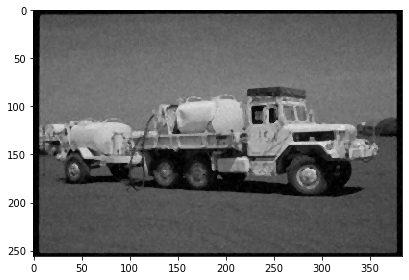

In [156]:
median = cv2.medianBlur(noisy, 3)
io.imsave('./Median.bmp', median)
io.imshow(median)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


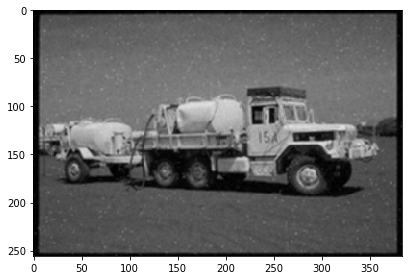

In [158]:
def operation(g, m, n, op=np.mean):
    assert m%2 == 1, n%2 == 1
    padded_g = cv2.copyMakeBorder(g.copy(), m//2, m//2, n//2, n//2, cv2.BORDER_REFLECT)
    H, W = g.shape
    f = np.zeros(g.shape)
    for h in range(H):
        for w in range(W):
            f[h][w] = (op(padded_g[h:h+m, w:w+n]))/(m*n)
    return f

def adaptive_wiener_filter(noisy, m, n, noise_var):
    H, W = noisy.shape
    padded = cv2.copyMakeBorder(noisy.copy(), m//2, m//2, n//2, n//2, cv2.BORDER_REFLECT)
    result = np.zeros(noisy.shape)
    for h in range(H):
        for w in range(W):
            local_patch = padded[h:h+m, w:w+n]
            value = local_patch[m//2, n//2]
            weighted = 1/(1+np.square(local_patch-value))
            normalized = weighted/(weighted.sum()+1e-8)
            local_mean = (normalized*local_patch).sum()
            local_var = (normalized*np.square(local_patch-local_mean)).sum()
            result[h,w] = local_mean + (value-local_mean)*local_var/(local_var+noise_var)
    return result

wiener = adaptive_wiener_filter(noisy, 3, 3, 50)
io.imshow(wiener, cmap='gray')
io.imsave('./Wiener.bmp', wiener)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


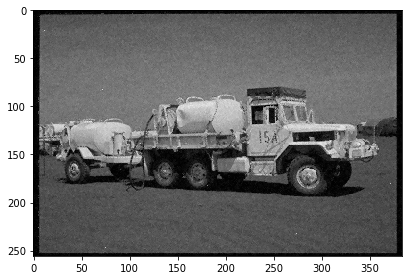

In [188]:
def level(patch, z_xy, s_xy, s_max):
    z_min, z_max, z_med = patch.min(), patch.max(), np.median(patch)
    if z_min < z_med and z_med < z_max:
        if z_min < z_xy and z_xy < z_max:
            return z_xy
        else:
            return z_med
    
def adaptive_median_filter(im, M, N, s_max):
    assert M%2==1, N%2==1
    H, W = im.shape
    padded = cv2.copyMakeBorder(noisy.copy(), M//2, M//2, N//2, N//2, cv2.BORDER_REFLECT)
    result = np.zeros(im.shape)
    
    for h in range(H):
        for w in range(W):
            value = None
            m, n = M, N
            while value==None:
                value = level(padded[h:h+m, w:w+n], im[h, w], m, s_max)
                if m <= s_max:
                    m, n = m+2, n+2
                else:
                    value = np.median(padded[h:h+m, w:w+n])
#                     value = im[h, w]
                    
            result[h,w] = value
    return result

adaptive_median = adaptive_median_filter(noisy, 3, 3, 5)
io.imshow(adaptive_median, cmap='gray')
io.imsave('./AdaptiveMedian.bmp', adaptive_median)

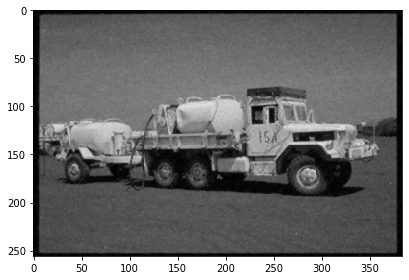

In [249]:
# def wiener_filter(im, K):
#     kernel = cv2.getGaussianKernel(3, 0)
#     kernel = kernel/kernel.sum()
#     dummy = fft.fft2(im.copy())
#     kernel = fft.fft2(kernel, s = im.shape)
#     kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
#     dummy = np.abs(fft.ifft2(dummy * kernel))
#     return dummy

# self_designed = wiener_filter(noisy, 20)
# details = np.clip(adaptive_median - adaptive_wiener_filter(adaptive_median, 3, 3, 10), 0, 1)
# self_designed = 0.1*details + adaptive_median
# io.imshow(self_designed, cmap='gray')

im1 = adaptive_median_filter(noisy, 7, 7, 10)
# im2 = wiener_filter(im1, 10)
# im3 = 0.3*np.clip((im1 - im2), 0, 1) + im1
self_designed = (cv2.GaussianBlur(im1, (3, 3), 3) + adaptive_median)/2
# im3 = np.clip(adaptive_median_filter(noisy, 7, 7, 10) - im3, 0, 1)
# im3[im3>0.5] = 0
# im2 = adaptive_wiener_filter(im1, 3, 3, 5)
io.imshow(self_designed, cmap='gray')

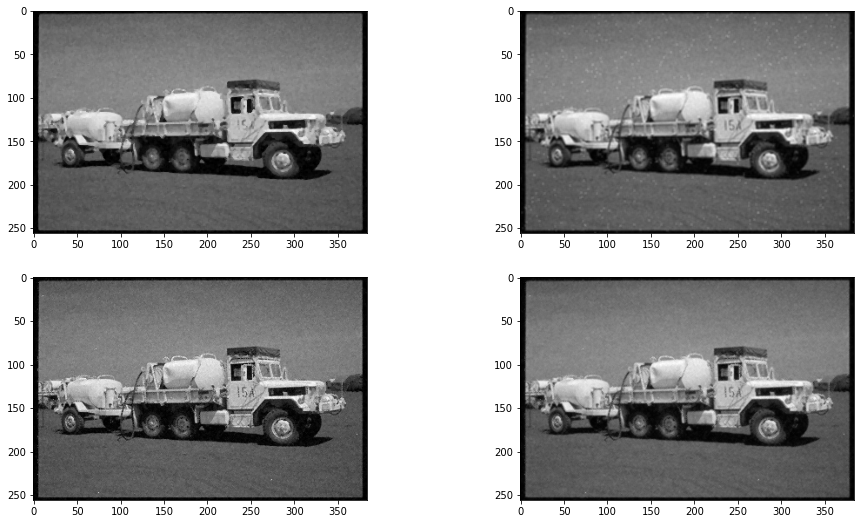

In [254]:
f, axarr = plt.subplots(2,2)
"""Although my own method is a bit blurry than adaptive-filtering,
   it includes less noise and look more realistic. It's more 
   clear than adaptive wiener and remove more noise. way clearer 
   than naive median filtering. """
fig = plt.gcf()
fig.set_size_inches(16, 9)
axarr[0,0].imshow(median, cmap='gray')
axarr[0,1].imshow(wiener, cmap='gray')
axarr[1,0].imshow(adaptive_median, cmap='gray')
axarr[1,1].imshow(self_designed, cmap='gray')
io.imsave('./ResultA.bmp', self_designed)


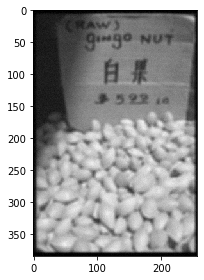

In [255]:
"""problem 2"""
noisy = read_img('./NoisyBlur.bmp', True)
io.imshow(noisy)

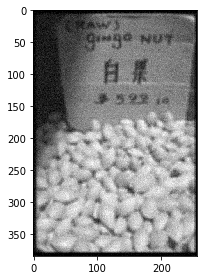

In [303]:
def iterative_deconvolution(im, beta, k, sigma, itr):
    curr = im.copy()
    for i in range(itr):
        blurry = cv2.GaussianBlur(curr, (k, k), sigma)
        details = im - blurry
        curr += beta*details
    return np.clip(curr, 0, 1)
deconv = iterative_deconvolution(noisy, 0.2, 3, 3, 10)
io.imshow(deconv, cmap='gray')

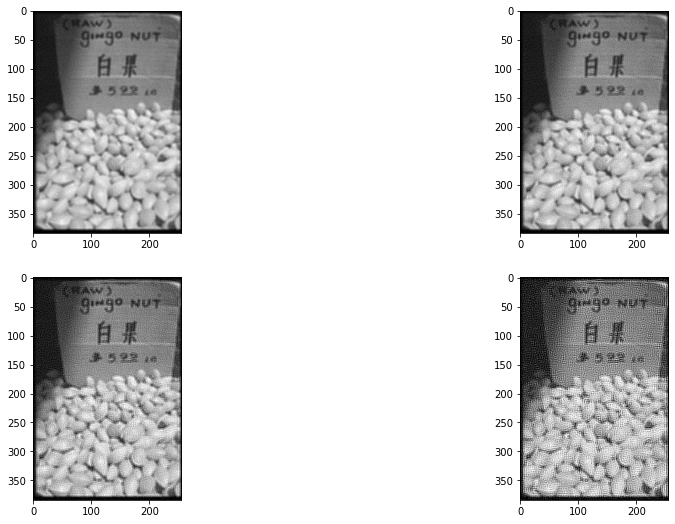

In [307]:
f, axarr = plt.subplots(2,2)
lst = [iterative_deconvolution(noisy, 0.1, 5, 5, i) for i in [10, 20, 40, 80]]
fig = plt.gcf()
fig.set_size_inches(16, 9)
axarr[0,0].imshow(lst[0], cmap='gray')
axarr[0,1].imshow(lst[1], cmap='gray')
axarr[1,0].imshow(lst[2], cmap='gray')
axarr[1,1].imshow(lst[3], cmap='gray')

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


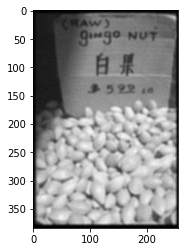

In [316]:
resultB = iterative_deconvolution(noisy, 0.1, 5, 5, 3)
plt.imshow(resultB, cmap='gray')
io.imsave('./resultB.bmp', resultB)
# number of iterations: 3
# choice of β: 0.1

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


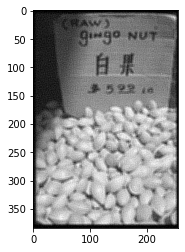

In [320]:
resultC = iterative_deconvolution(noisy, 0.1, 5, 5, 30)
plt.imshow(resultC, cmap='gray')
io.imsave('./resultC.bmp', resultC)
# number of iterations: 30
# choice of β: 0.1

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


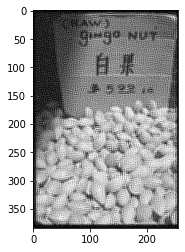

In [319]:
resultD = iterative_deconvolution(noisy, 0.1, 5, 5, 80)
plt.imshow(resultD, cmap='gray')
io.imsave('./resultD.bmp', resultD)
# number of iterations: 80
# choice of β: 0.1